In [1]:
import os
import random
import math
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from typing import List, Tuple, Optional

In [2]:
EMPTY, BLACK, WHITE = 0, 1, -1
DIRECTIONS = [(-1,-1),(-1,0),(-1,1),(0,-1),(0,1),(1,-1),(1,0),(1,1)]

In [3]:
def opponent(c):
    """現在のプレイヤーの相手を返す"""
    return -c

class Othello:
    def __init__(self):
        self.board = [[EMPTY for _ in range(8)] for _ in range(8)]
        self.board[3][3] = self.board[4][4] = WHITE
        self.board[3][4] = self.board[4][3] = BLACK
        self.player = BLACK

    def clone(self):
        """盤面をコピーして新しいインスタンスを返す"""
        g = Othello()
        g.board = [row[:] for row in self.board]
        g.player = self.player
        return g

    def inside(self, r, c):
        """
        盤面の範囲内かを返す
        Args:
            r (int): 行
            c (int): 列
        Returns:
            bool: 盤面の範囲内か
        """
        return 0 <= r < 8 and 0 <= c < 8

    def legal_moves(self, player=None) -> List[Tuple[int, int]]:
        """
        合法手を返す
        Args:
            player (int, optional): プレイヤーの色.指定しない場合は現在のプレイヤーを返す
        Returns:
            List[Tuple[int, int]]: 合法手のリスト
        """
        if player is None:
            player = self.player
        moves = []
        for r in range(8):
            for c in range(8):
                if self.board[r][c] != EMPTY:  # 空白でない場合は合法手ではない
                    continue
                if self._would_flip(r, c, player):  # 石をひっくり返せる場合は合法手
                    moves.append((r, c))
        return moves

    def _would_flip(self, r, c, player) -> bool:
        """
        石をひっくり返せるかを返す
        Args:
            r (int): 行
            c (int): 列
            player (int): プレイヤーの色
        Returns:
            bool: 石をひっくり返せるか
        """
        if self.board[r][c] != EMPTY:  # 空白でない場合は石をひっくり返せない
            return False
        for dr, dc in DIRECTIONS:
            rr, cc = r + dr, c + dc
            seen_opp = False  # 相手の石を一度見たか
            while self.inside(rr, cc) and self.board[rr][cc] == opponent(player):  # 盤面の範囲内か & 相手の石が置かれている場所か
                seen_opp = True
                rr += dr; cc += dc
            if seen_opp and self.inside(rr, cc) and self.board[rr][cc] == player:  # 相手の石を一度見たか & 盤面の範囲内か & 自分の石をみたか
                return True
        return False

    def play(self, r, c, player=None):
        """
        石を置く & 石をひっくり返す
        Args:
            r (int): 行
            c (int): 列
            player (int, optional): プレイヤーの色.指定しない場合は現在のプレイヤーを返す
        """
        if player is None:
            player = self.player
        assert self.board[r][c] == EMPTY  # 空白でない場合は石を置くことができない
        flipped = []
        for dr, dc in DIRECTIONS:
            line = []
            rr, cc = r + dr, c + dc
            while self.inside(rr,cc) and self.board[rr][cc] == opponent(player):  # 盤面の範囲内か & 相手の石が置かれている場所か
                line.append((rr,cc))  # 石をひっくり返す場所を追加
                rr += dr; cc += dc
            if line and self.inside(rr,cc) and self.board[rr][cc] == player:  # 石をひっくり返す場所が存在 & 盤面の範囲内か & 自分の石をみたか
                flipped.extend(line)  # 石をひっくり返す場所を追加
        if not flipped:  # 石をひっくり返す場所が存在しない場合は不正な手
            raise ValueError("Illegal move")
        self.board[r][c] = player
        for rr,cc in flipped:  # 石をひっくり返す
            self.board[rr][cc] = player
        self.player = opponent(player)
        # 現在のプレイヤーが合法手がない場合は相手の番
        if not self.legal_moves(self.player):
            self.player = opponent(self.player)

    def terminal(self) -> bool:
        if self.legal_moves(BLACK): return False
        if self.legal_moves(WHITE): return False
        return True

    def score(self) -> int:
        """
        黒が+1, 白が-1としてスコアを計算
        Returns:
            int: スコア
        """
        s = 0
        for r in range(8):
            for c in range(8):
                s += self.board[r][c]
        return s

    def winner(self) -> int:
        s = self.score()
        return BLACK if s > 0 else WHITE if s < 0 else 0

In [4]:
# Features（軽量・GPU不要）
CORNER_CELLS = [(0, 0), (0, 7), (7, 0), (7, 7)]
XCELLS = [  # コーナー隣接(危険)
    (0,1),(1,0),(1,1),
    (0,6),(1,6),(1,7),
    (6,0),(6,1),(7,1),
    (6,6),(6,7),(7,6)
]
EDGE_CELLS = [(0,c) for c in range(2, 6)] + [(7,c) for c in range(2, 6)] + \
[(r,0) for r in range(2, 6)] + [(r,7) for r in range(2, 6)]  # エッジ（コーナー・コーナー隣接除く）

def features(game: Othello, player: int):
    """
    特徴量を返す
    Args:
        game: Othello
        player: int
    Returns:
        list: 特徴量
    """
    b = game.board
    f_bias = 1.0

    # 石の数（率）
    disc = sum(b[r][c] for r in range(8) for c in range(8))
    my_disc = 0
    opp_disc = 0
    for r in range(8):
        for c in range(8):
            if b[r][c] == player:
                my_disc += 1
            elif b[r][c] == -player:
                opp_disc += 1
    f_parity = (my_disc - opp_disc) / 64.0  # 石差

    # モビリティ(合法手数)
    my_moves = len(game.legal_moves(player))
    opp_moves = len(game.legal_moves(-player))
    f_mobility = (my_moves - opp_moves) / 20.0  # 正規化

    # コーナー占有率
    def count_cells(cells, who):
        return sum(1 for r,c in cells if b[r][c] == who)
    f_corner = (count_cells(CORNER_CELLS, player) - count_cells(CORNER_CELLS, -player)) / 4.0

    # Xセル占有率
    f_x = (count_cells(XCELLS, player) - count_cells(XCELLS, -player)) / 12.0 * (-1.0)

    # 辺の占有率
    f_edge = (count_cells(EDGE_CELLS, player) - count_cells(EDGE_CELLS, -player)) / 16.0

    return [f_bias, f_parity, f_mobility, f_corner, f_x, f_edge]

class LinearValue:
    """
    線形価値関数
    """
    def __init__(self, n_feat):
        self.w = [0.0]*n_feat

    def value(self, phi):
        """
        特徴量の値を返す
        Args:
            phi: 特徴量
        Returns:
            float: 値
        """
        return (sum(wi*fi for wi,fi in zip(self.w, phi)))  # 重みと特徴量の内積を返す

    def update(self, phi, target, alpha):
        """
        更新
        Args:
            phi: 特徴量
            target: 目標値
            alpha: 学習率
        """
        v = self.value(phi)  # 現在の価値
        delta = target - v  # 目標値と現在の価値の差
        for i in range(len(self.w)):  # 重みを更新(n_feat分)
            self.w[i] += alpha * delta * phi[i]  # 重みを更新
        return delta

def choose_move(game: Othello, player: int, V: LinearValue, eps=0.1):
    """
    ε-greedyで行動を選択
    Args:
        game: Othello
        player: int
        V: LinearValue（線形価値関数）
        eps: float
    Returns:
        tuple: 選択した手
    """
    moves = game.legal_moves(player)  # 合法手
    if not moves:
        return None
    # eps未満の確率でランダム選択
    if random.random() < eps:
        return random.choice(moves)
    # afterstateの価値で貪欲選択
    best_v = -1e9  # 初期値をごく小さい値に設定
    best_m = moves[0]
    for m in moves:
        g2 = game.clone()
        g2.play(m[0], m[1], player)
        phi = features(g2, player)
        v = V.value(phi)
        if v > best_v:
            best_v, best_m = v, m
    return best_m

def choose_move_opponent(game: Othello, player: int, V: LinearValue, eps=0.05, tol=1e-12):
    """
    学習時の「相手」用の手選び。
    方針:
        1) 角が取れるなら必ず角（同値はランダム）
        2) 可能ならXマスは避ける
        3) 可能なら辺を優先
        4) 残りは小さめεでランダム、それ以外はVで貪欲（同値ランダム）
    """
    moves = game.legal_moves(player)
    if not moves:
        return None

    corners = {(0,0),(0,7),(7,0),(7,7)}
    xset = set(XCELLS)                  # 12マス
    edges = set(EDGE_CELLS)             # 28マス（重複が気になるならユニーク化してOK）

    # 1) 角は必ず取る
    corner_moves = [m for m in moves if m in corners]
    if corner_moves:
        best_v, cands = -1e18, []
        for m in corner_moves:
            g2 = game.clone(); g2.play(m[0], m[1], player)
            v = V.value(features(g2, player))
            if v > best_v + tol:
                best_v, cands = v, [m]
            elif abs(v - best_v) <= tol:
                cands.append(m)
        return random.choice(cands)

    # 2) Xは極力避ける
    pool = [m for m in moves if m not in xset] or moves

    # 3) 辺を優先
    edge_pool = [m for m in pool if m in edges] or pool

    # 4) 小さめεでランダム、それ以外はVで貪欲（同値ランダム）
    if random.random() < eps:
        return random.choice(edge_pool)

    best_v, cands = -1e18, []
    for m in edge_pool:
        g2 = game.clone(); g2.play(m[0], m[1], player)
        v = V.value(features(g2, player))
        if v > best_v + tol:
            best_v, cands = v, [m]
        elif abs(v - best_v) <= tol:
            cands.append(m)
    return random.choice(cands)

def play_one_game(
    V: LinearValue, alpha=0.01, eps=0.1, learn=True,
    use_heuristic_opponent=False, opp_color=WHITE, opp_eps=0.05
):
    """
    1ゲームプレイ
    use_heuristic_opponent=True なら、opp_color 側の手は choose_move_opponent を使う。
    それ以外は従来通り ε-greedy。
    Args:
        V: LinearValue（線形価値関数）
        alpha: float（学習率）
        eps: float（ε）
        learn: bool（学習フラグ）
    Returns:
        int: 勝敗
    """
    g = Othello()  # インスタンス
    histories = []  # (phi_before, player_before)

    # 自己対戦（両者同じVを参照）
    while not g.terminal():  # 終局まで
        p = g.player
        if use_heuristic_opponent and p == opp_color:  # 相手の手はheuristic + epsilon-greedy
            m = choose_move_opponent(g, p, V, eps=opp_eps)
        else:
            m = choose_move(g, p, V, eps=eps)
        if m is None:
            # パス処理はOthello.play内で自動、ここは保険
            g.player = opponent(g.player)
            continue
        # 着手前→着手後(afterstate)
        g2 = g.clone()
        g2.play(m[0], m[1], p)  # 特徴量計算のための着手シミュレーション
        phi_after = features(g2, p)  # 着手後の特徴量を計算
        histories.append((phi_after, p))  # 特徴量とプレイヤーを保存
        g.play(m[0], m[1], p)  # 実着手

    # 終局報酬（BLACK=+1, WHITE=-1, 引き分け0）
    w = g.winner()
    reward_black = 1.0 if w == BLACK else -1.0 if w == WHITE else 0.0

    if learn:
        # TD(0) with afterstates: V(s_t) <- V(s_t) + alpha*(G - V(s_t)), ここではエピソード末の目標に収束
        # 終局時は γ=1, 目標は「勝ったら+1/負けたら-1」
        for phi, p in histories:
            target = reward_black if p == BLACK else -reward_black
            V.update(phi, target, alpha)
    return w

def train(num_games=5000, alpha=0.01, eps=0.2, seed=0):
    """
    強化学習の実行
    Args:
        num_games: int（ゲーム数）
        alpha: float（学習率）
        eps: float（ε）
        seed: int（乱数シード）
    Returns:
        None
    """
    random.seed(seed)
    V = LinearValue(n_feat=len(features(Othello(), BLACK)))
    results = {BLACK:0, WHITE:0, 0:0}
    train_history = []

    for i in range(1, num_games+1):
        w = play_one_game(V, alpha=alpha, eps=eps, learn=True)
        results[w] += 1
        if i % 10 == 0:
            total = i
            train_history.append({
                "game": i,
                "black": results[BLACK]/total*100,
                "white": results[WHITE]/total*100,
                "D": results[0]/total*100,
                "draw": results[0]/total*100,
            })
            wr_black = results[BLACK]/total*100
            wr_white = results[WHITE]/total*100
            print(f"[{i}] B:{wr_black:.1f}% W:{wr_white:.1f}% Draw:{results[0]/total*100:.1f}%")
    return V, train_history

def plot_train_history(train_history):
    """
    学習履歴を可視化
    Args:
        train_history: list（学習履歴）
    Returns:
        None
    """
    xs = [h['game'] for h in train_history]
    b = [h["black"] for h in train_history]
    w = [h["white"] for h in train_history]
    d = [h["draw"] for h in train_history]
    plt.figure(figsize=(7, 4))
    plt.plot(xs, b, label="Black Win %")
    plt.plot(xs, w, label="White Win %")
    plt.plot(xs, d, label="Draw %")
    plt.xlabel("Games")
    plt.ylabel("Win Rate %")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def play_match(V: LinearValue, eps=0.0, games=50, seed=1):
    """
    対局を行う
    Args:
        V (LinearValue): 価値関数
        eps (float): 探索割合
        games (int): 対局数
        seed (int): seed
    """
    random.seed(seed)
    res = {BLACK:0, WHITE:0, 0:0}
    for _ in range(games):
        # 学習はOFF
        w = play_one_game(V, alpha=0.0, eps=eps, learn=False)
        res[w] += 1
    print(f"vs greedy self  ({games} games): B={res[BLACK]} W={res[WHITE]} D={res[0]}")
    return res

[10] B:20.0% W:70.0% Draw:10.0%
[20] B:25.0% W:70.0% Draw:5.0%
[30] B:26.7% W:70.0% Draw:3.3%
[40] B:22.5% W:75.0% Draw:2.5%
[50] B:20.0% W:78.0% Draw:2.0%
[60] B:18.3% W:78.3% Draw:3.3%
[70] B:17.1% W:78.6% Draw:4.3%
[80] B:20.0% W:75.0% Draw:5.0%
[90] B:22.2% W:72.2% Draw:5.6%
[100] B:25.0% W:70.0% Draw:5.0%
[110] B:27.3% W:67.3% Draw:5.5%
[120] B:29.2% W:65.8% Draw:5.0%
[130] B:29.2% W:66.2% Draw:4.6%
[140] B:29.3% W:66.4% Draw:4.3%
[150] B:29.3% W:66.0% Draw:4.7%
[160] B:30.6% W:65.0% Draw:4.4%
[170] B:32.4% W:63.5% Draw:4.1%
[180] B:33.3% W:62.8% Draw:3.9%
[190] B:34.2% W:62.1% Draw:3.7%
[200] B:34.0% W:62.5% Draw:3.5%
[210] B:34.8% W:61.9% Draw:3.3%
[220] B:34.5% W:62.3% Draw:3.2%
[230] B:34.3% W:62.6% Draw:3.0%
[240] B:34.6% W:62.5% Draw:2.9%
[250] B:34.8% W:62.4% Draw:2.8%
[260] B:33.8% W:63.5% Draw:2.7%
[270] B:33.7% W:63.7% Draw:2.6%
[280] B:33.9% W:63.2% Draw:2.9%
[290] B:34.8% W:62.4% Draw:2.8%
[300] B:35.3% W:62.0% Draw:2.7%
[310] B:35.8% W:61.6% Draw:2.6%
[320] B:36.6% W:

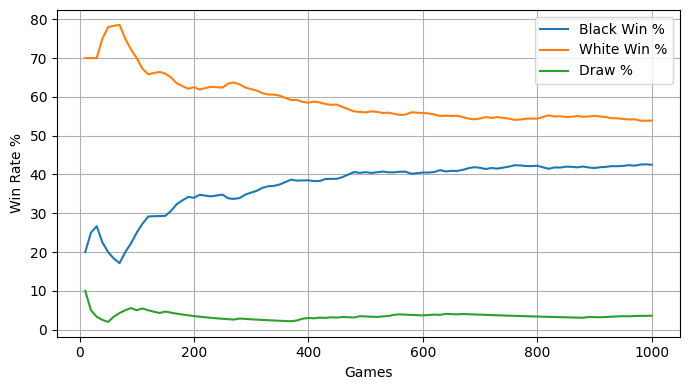

Weights: [0.009239688285456156, 0.4593795918765389, -0.16149816712796689, 0.5377384772530641, -0.46910892362715784, -0.3521335422906889]


In [5]:
V, train_history = train(num_games=1000, alpha=0.02, eps=0.2, seed=42)
plot_train_history(train_history)
print(f"Weights: {V.w}")

In [6]:
def print_board(game: Othello):
    """
    盤面を表示する。
    表示する際、現在の出力を削除して新たに表示する。
    """
    b = game.board
    header = "   " + " ".join([chr(ord('a')+c) for c in range(8)])
    print(header)
    for r in range(8):
        line = f"{r+1:2d} "
        for c in range(8):
            if b[r][c] == BLACK: ch = "○"
            elif b[r][c] == WHITE: ch = "●"
            else: ch = "."
            line += ch + " "
        print(line)
    turn = "Black(●)" if game.player == BLACK else "White(○)"
    print(f"Turn: {turn}")

def parse_move(s: str):
    """
    s: "a1", "pass", "p"
    """
    s = s.strip().lower()
    if s in ("pass", "p"): return None
    if len(s) != 2: return "ERR"
    col = ord(s[0]) - ord('a')
    row = ord(s[1]) - ord('1')
    if 0 <= row < 8 and 0 <= col < 8:
        return (row, col)
    return "ERR"

def human_vs_agent(V: LinearValue, human_color=BLACK, seed=123):
    """
    人間と学習済みVで対戦。human_color は BLACK か WHITE。
    """
    random.seed(seed)
    g = Othello()
    while not g.terminal():
        print_board(g)
        p = g.player
        if p == human_color:
            moves = g.legal_moves(p)
            if not moves:
                print("No legal moves. Pass.")
                g.player = opponent(g.player)
                continue
            s = input("Your move (e.g., d3 / pass / quit): ").strip().lower()
            if s in ("quit", "q"):
                print("Quit.")
                return
            mv = parse_move(s)
            if mv == "ERR":
                print("Format error. Try again.")
                continue
            if mv is None:
                # pass
                g.player = opponent(g.player)
                continue
            if mv not in moves:
                print("Illegal. Try again.")
                continue
            g.play(mv[0], mv[1], p)
        else:
            # エージェント手
            m = choose_move(g, p, V)  # 完全貪欲（同値ランダム）
            if m is None:
                print("(Agent) Pass.")
                g.player = opponent(g.player)
                continue
            print(f"(Agent) move: {chr(ord('a')+m[1])}{m[0]+1}")
            g.play(m[0], m[1], p)

    print_board(g)
    w = g.winner()
    if w == 0:
        print("Draw!")
    elif w == BLACK:
        print("Black(●) wins!")
    else:
        print("White(○) wins!")

In [7]:
# 人間が白（⚫︎）、エージェントが黒（○）
human_vs_agent(V, human_color=WHITE, seed=2025)

   a b c d e f g h
 1 . . . . . . . . 
 2 . . . . . . . . 
 3 . . . . . . . . 
 4 . . . ● ○ . . . 
 5 . . . ○ ● . . . 
 6 . . . . . . . . 
 7 . . . . . . . . 
 8 . . . . . . . . 
Turn: Black(●)
(Agent) move: d3
   a b c d e f g h
 1 . . . . . . . . 
 2 . . . . . . . . 
 3 . . . ○ . . . . 
 4 . . . ○ ○ . . . 
 5 . . . ○ ● . . . 
 6 . . . . . . . . 
 7 . . . . . . . . 
 8 . . . . . . . . 
Turn: White(○)
Format error. Try again.
   a b c d e f g h
 1 . . . . . . . . 
 2 . . . . . . . . 
 3 . . . ○ . . . . 
 4 . . . ○ ○ . . . 
 5 . . . ○ ● . . . 
 6 . . . . . . . . 
 7 . . . . . . . . 
 8 . . . . . . . . 
Turn: White(○)
Quit.
